In [7]:
import tensorflow as tf
import os

In [8]:
BUFFER_SIZE = 10000 
BATCH_SIZE = 128    
EPOCHS = 150        
NOISE_DIM = 100
IMG_ROWS = 128
IMG_COLS = 128
CHANNELS = 1

DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
# --- Data Loading and Preprocessing ---
def load_and_preprocess_dataset(data_dir):
    # Use Keras utility to load images from the directory
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels=None,
        color_mode='grayscale',
        image_size=(IMG_ROWS, IMG_COLS),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    # Normalization function to scale pixels from [0, 255] to [-1, 1]
    def normalize(image):
        image = (tf.cast(image, tf.float32) - 127.5) / 127.5
        return image
     # Apply the normalization to every image in the dataset
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE)
    
    # Cache and prefetch for performance
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    
    print("✅ Dataset loaded and preprocessed successfully.")
    return dataset
train_dataset = load_and_preprocess_dataset(DATA_DIR)


Found 5216 files.
✅ Dataset loaded and preprocessed successfully.


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()

    # Foundation: Start with a dense layer and reshape it
    # We start with 8x8 which will be upsampled to 128x128 (8 -> 16 -> 32 -> 64 -> 128)
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    # Upsampling Block 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsampling Block 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsampling Block 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsampling Block 4 (Output): 64x64 -> 128x128
    # The final layer uses 'tanh' activation to scale output to [-1, 1]
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_ROWS, IMG_COLS, CHANNELS)

    return model

# ==============================================================================
#  3. DISCRIMINATOR MODEL 🔬
# ==============================================================================
# A standard CNN classifier to distinguish real vs. fake images.

def make_discriminator_model():
    model = tf.keras.Sequential()
    input_shape = (IMG_ROWS, IMG_COLS, CHANNELS)

    # Downsampling Block 1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsampling Block 2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Downsampling Block 3
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and classify
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # No sigmoid here, as we use from_logits=True in the loss

    return model

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# ==============================================================================
#  4. LOSS FUNCTIONS & OPTIMIZERS
# ==============================================================================
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # The generator wants the discriminator to think its images are real (label 1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Use the Adam optimizer for both networks
# A lower learning rate and beta_1 are often recommended for GAN stability
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# ==============================================================================
#  5. TRAINING STEP
# ==============================================================================

# Notice the use of `tf.function`
# This decorator compiles the function into a high-performance TensorFlow graph.
@tf.function
def train_step(images):
    # Generate noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for both real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


# ==============================================================================
#  6. TRAINING LOOP & VISUALIZATION
# ==============================================================================

def generate_and_save_images(model, epoch, test_input):
    # `training=False` ensures layers like BatchNormalization run in inference mode
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # De-normalize from [-1, 1] to [0, 1] for display
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()

# We will reuse this seed overtime to visualize progress on the same noise vectors
seed = tf.random.normal([16, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch_num, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            
        # Produce a plot of generated images at the end of each epoch
        generate_and_save_images(generator, epoch + 1, seed)
        
        avg_gen_loss = total_gen_loss / (batch_num + 1)
        avg_disc_loss = total_disc_loss / (batch_num + 1)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
        print(f'Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}')

    # Final generation after training is complete
    generate_and_save_images(generator, epochs, seed)

# --- Start Training ---
print("🚀 Starting GAN Training...")
train(train_dataset, EPOCHS)
print("✅ Training Complete!")

🚀 Starting GAN Training...


E0000 00:00:1758861046.621497      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Time for epoch 1 is 19.02 sec
Generator Loss: 1.8706, Discriminator Loss: 0.4932
Time for epoch 2 is 11.66 sec
Generator Loss: 2.8966, Discriminator Loss: 0.4610
Time for epoch 3 is 11.64 sec
Generator Loss: 4.2270, Discriminator Loss: 0.3861
Time for epoch 4 is 11.64 sec
Generator Loss: 5.0744, Discriminator Loss: 0.2988
Time for epoch 5 is 11.64 sec
Generator Loss: 3.6742, Discriminator Loss: 0.1917
Time for epoch 6 is 11.64 sec
Generator Loss: 3.6318, Discriminator Loss: 0.2976
Time for epoch 7 is 11.65 sec
Generator Loss: 3.3026, Discriminator Loss: 0.4024
Time for epoch 8 is 11.67 sec
Generator Loss: 3.1657, Discriminator Loss: 0.7007
Time for epoch 9 is 12.10 sec
Generator Loss: 2.6640, Discriminator Loss: 0.6024
Time for epoch 10 is 11.72 sec
Generator Loss: 2.1765, Discriminator Loss: 0.9630
Time for epoch 11 is 11.66 sec
Generator Loss: 1.6369, Discriminator Loss: 0.6708
Time for epoch 12 is 11.65 sec
Generator Loss: 1.3862, Discriminator Loss: 0.7834
Time for epoch 13 is 11.6

In [14]:
# Assuming your generator model is in a variable named 'generator'
generator.save('chest_xray_generator.keras')

print("✅ Generator model saved!")

✅ Generator model saved!


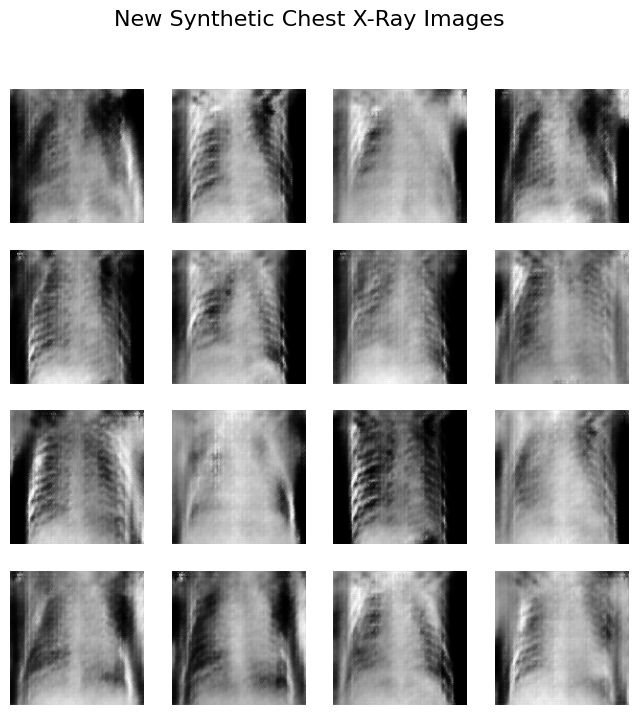

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the saved generator model
saved_generator = tf.keras.models.load_model('chest_xray_generator.keras')

# 2. Define the number of images to generate and noise dimension
num_images_to_generate = 16
noise_dim = 100 # Must be the same as during training

# 3. Create random noise vectors
random_noise = tf.random.normal([num_images_to_generate, noise_dim])

# 4. Generate images
# The 'training=False' is important as it deactivates layers like Dropout
generated_images = saved_generator(random_noise, training=False)

# 5. Rescale images from [-1, 1] to [0, 255] and display them
fig = plt.figure(figsize=(8, 8))

for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    # De-normalize the image from tanh's [-1, 1] range to the standard [0, 255] pixel range
    img = (generated_images[i, :, :, 0] * 127.5 + 127.5).numpy().astype(np.uint8)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.suptitle("New Synthetic Chest X-Ray Images", fontsize=16)
plt.show()

In [3]:
# Run this in a new cell in your notebook
!ls -l /kaggle/input/chest-xray-pneumonia/chest_xray/train

total 0
drwxr-xr-x 2 nobody nogroup 0 Jan  6  2025 NORMAL
drwxr-xr-x 2 nobody nogroup 0 Jan  6  2025 PNEUMONIA
